# ADA final exam (Fall 2021)

This exam consists of 2 parts.
The first part has 3 tasks.
The second part has 2 tasks.
The two parts are completely independent of each other.

## Important: The data used for this exam **is not entirely real.** A great deal of it has been artificially created or modified. Conclusions drawn from this data have no real link to reality!

In [2]:
%matplotlib inline

# General
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For graph-related stuff
import networkx as nx

# For regression analyses and statistical tests
import scipy.stats as stats
import statsmodels.stats
import statsmodels.formula.api as smf

# For classification
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Styling
sns.set_style("darkgrid")


## Part 1 — Faculty hiring network

For the first part of the exam, you will analyze data from a faculty hiring network. After completing their Ph.D., researchers who want to pursue an academic career must compete for relatively few permanent positions (as “faculty”, i.e., professors) in a highly competitive job market. You will analyze a directed graph that captures the dynamics of this hiring process in the United States:


- Each node $u$ in this graph represents a different American university.
- For each university, we also provide a score that captures how highly  this university is ranked (e.g., Stanford University is ranked more highly than the University of Alabama). The higher the score, the more highly ranked the university.
- Each directed edge $(u,v)$ in this graph represents a hiring decision where someone who did their Ph.D. at university $u$ subsequently was hired by university $v$. Each edge is also associated with a gender label, which specifies if the person hired was a man (M) or a woman (F).
- Note that, when multiple researchers were trained at a given university $u$ and subsequently hired by university $v$, there will be multiple edges pointing from $u$ to $v$, each of which corresponds to a different person.

## Files (in the `./data/part-1/` folder)

- `nodelist.tsv` a tab-separated file containing the nodes of the graph. Recall that each node represents a different university. The file has these columns:
    - `u` — the node index;
    - `score` — the rank of the university (the higher the better);
    - `name` — the name of the university.

- `edgelist.tsv` a tab-separated file containing the edges of the graph. Recall that each edge represents a hiring decision. The file has columns:
    - `u` — the source university, where the person got their Ph.D.;
    - `v` — the target university, where the person was hired;
    - `gender` — the gender of the person.


### Task 1 — (20 points)

1. Using the above files, create the directed graph representing the hiring network using `networkx`.
Each node should contain the attributes `score` and `name`, and each edge should contain the attribute `gender`.
Print the total numbers of nodes and edges in the graph.

2. Create a plot that allows you to easily visualize **(a)** what fraction of all researchers in the graph are hired by the $N$ universities that hire the most; and  **(b)** what fraction of all researchers in the graph are trained by the $N$ universities whose students get hired the most.
Here, $N$ could be any number between 1 and the number of universities.

3. **/Multiple choice:/** Which centrality metric(s) is/are illustrated in the plot you made for the previous subtask? Select all that apply from the list below and **justify your answer.**
    1. Betweenness centrality
    2. In-degree centrality
    3. Out-degree centrality
    4. PageRank centrality

4. **/True or false:/** Search engines such as Google have historically used PageRank centrality as a signal to determine the importance of pages on the Web. Is the following statement **true** or **false**? Justify. **"In the faculty hiring network, PageRank centrality is positively correlated with university score, that is, universities with higher scores are more likely to also have higher PageRank centrality."**


In [11]:
# Task 1 - 1
nodelist = pd.read_csv("data/part-1/nodelist.tsv", sep="\t")
edgelist = pd.read_csv("data/part-1/edgelist.tsv", sep="\t")

# Convert nodes and edges into iterable
nodes = [(u, {"score": score, "name": name}) for _, (u, score, name) in nodelist.iterrows()]
edges = [(u, v, {"gender": gender}) for _, (u, v, gender) in edgelist.iterrows()]

# Create graph
G = nx.MultiDiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Statistics
print(f"The graph contains {len(G.nodes())} nodes.")
print(f"The graph contains {len(G.edges())} edges.")

The graph contains 205 nodes.
The graph contains 4388 edges.


Plotted!


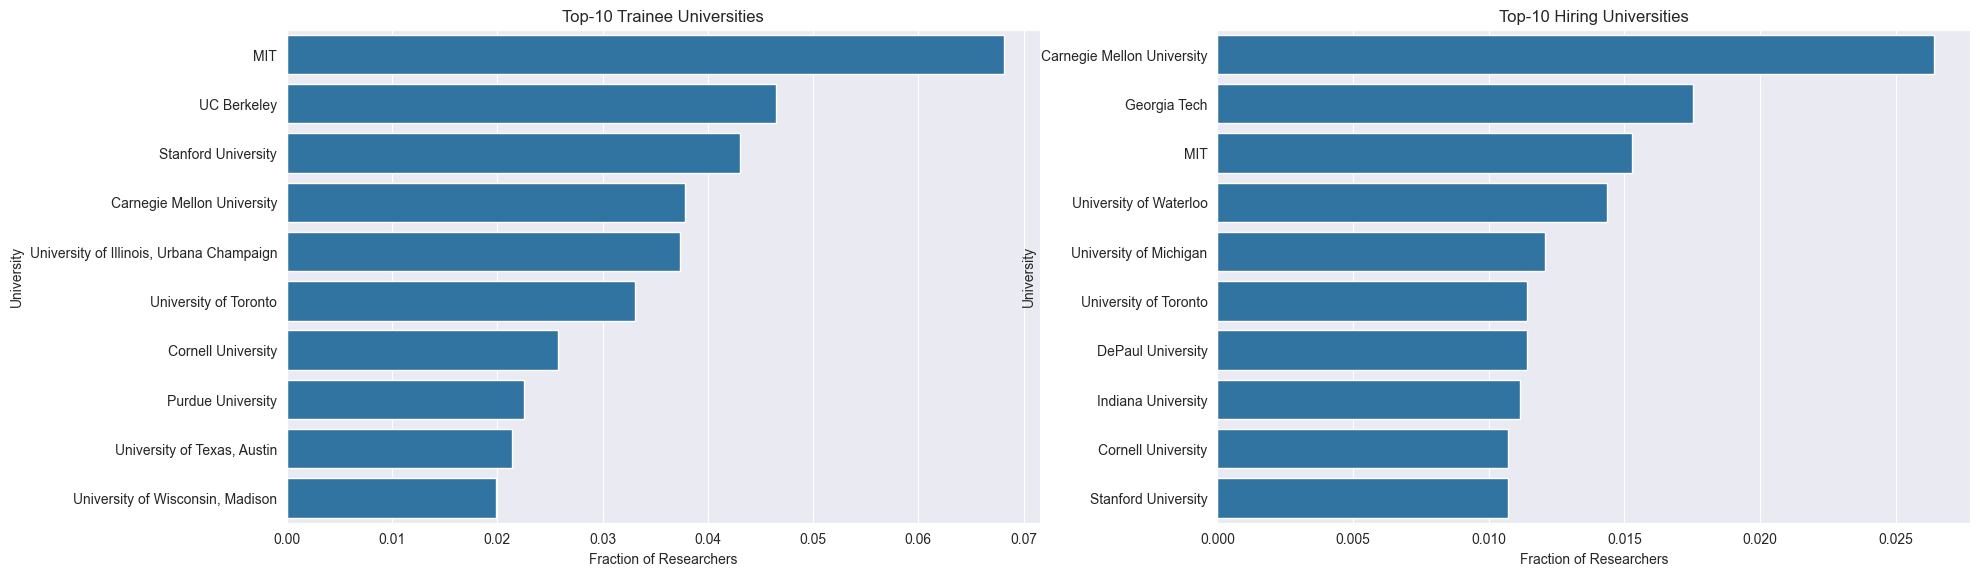

In [64]:
# Task 1 - 2
df = edgelist \
    .merge(nodelist, left_on="u", right_on="u", suffixes=(None, "_u")) \
    .merge(nodelist, left_on="v", right_on="u", suffixes=(None, "_v"))

N = 10
hired = (df.groupby("name_v").size() / len(df)).sort_values(ascending=False).head(N)
trained = (df.groupby("name").size() / len(df)).sort_values(ascending=False).head(N)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
fig.tight_layout(pad=10.0)
sns.barplot(y=trained.index, x=trained.values, order=trained.index, orient="h", ax=ax[0])
sns.barplot(y=hired.index, x=hired.values, order=hired.index, orient="h", ax=ax[1])

ax[0].set(
    title="Top-10 Trainee Universities",
    xlabel="Fraction of Researchers",
    ylabel="University"
)

ax[1].set(
    title="Top-10 Hiring Universities",
    xlabel="Fraction of Researchers",
    ylabel="University"
)

print("Plotted!")

**Task 1.3** We show normalised in-degree and out-degree centralities for the `N` universities with highest centralities. Here, in-degree centrality is the number of hires a university has made which is being shown in the right subplot (in a normalised way). Similarly, the out-degree centrality is the number of students a university has educated that got a faculty position at another university, which are shown as the trainee universities in the left subplot.

**Task 1.4** False. In PageRank, a node is important if many other important nodes link to it. However, in the hiring graph a university should be considered important if it links to many other important universities (e.g. the students are hired by high-ranked universities). As the notion of importance is flipped here, we would expect a negative correlation.

Correlation between scores and PageRank scores: -0.44


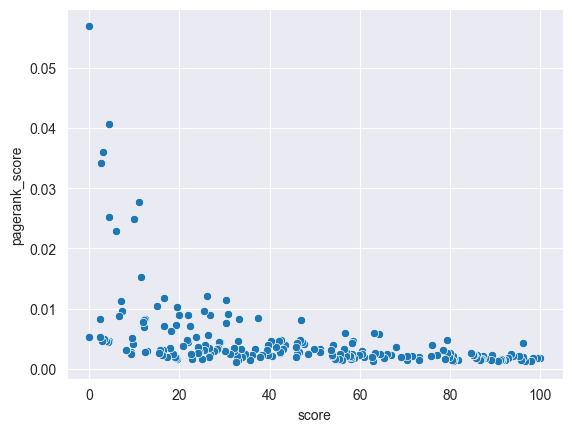

In [74]:
# Correlate PageRank scores with actual scores
from scipy.stats import pearsonr

nodelist["pagerank_score"] = nx.pagerank(G)
nodelist = nodelist.dropna()

sns.scatterplot(nodelist, x="score", y="pagerank_score")

res = pearsonr(x=nodelist.score, y=nodelist.pagerank_score)
print(f"Correlation between scores and PageRank scores: {res.correlation:.2f}")

### Task 2 — (15 points)

Each hiring decision $(u,v)$ connects two different universities with different scores.

1. Divide the universities into quintiles according to their scores ($Q_1$ to $Q_5$, where $Q_5$ contains the highest-ranked universities, i.e., those with the highest scores). Create a succinct plot that captures, for each pair of quintiles ($Q_i$, $Q_j$), what fraction of people in the dataset who got their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$.


2. **/Multiple choice:/** What does the plot made in the previous subtask reveal about the faculty hiring process? Select one of the following options and justify your answer.
    1. Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.
    2. Ph.D. graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

3. **/True or false:/** Let $E$ be the set of edges from the hiring network, and let $X$ be defined as follows:
$$X = \frac{|(u,v) \in E : u \in Q_1 \text{ and } v \in Q_5 |}{{|(u,v) \in E : u \in Q_1|}}$$
 *Thinking critically about the data that was given to you,* is the following statement **true** or **false**? Justify your answer. **"If I get my Ph.D. in a 1st-quintile university, I have a chance of around X * 100%  of getting a job in a 5th-quintile university."**


---
**Hints:**
- [pandas.qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) makes splitting data into quantiles easy!


Plotted.


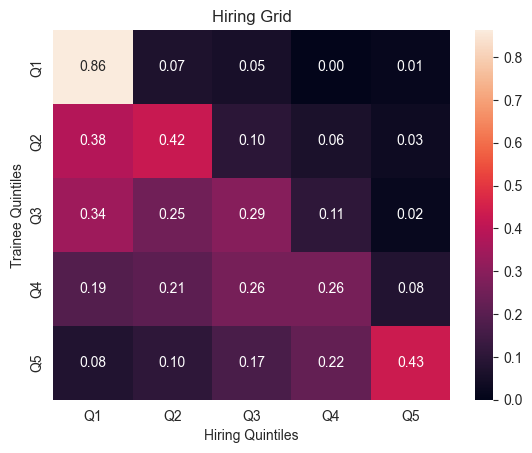

In [220]:
# Task 2 - 2
nodelist["quintile"] = pd.qcut(nodelist.score, 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])

df = edgelist \
    .merge(nodelist, left_on="u", right_on="u", suffixes=(None, "_u")) \
    .merge(nodelist, left_on="v", right_on="u", suffixes=(None, "_v"))

hiring_grid = df \
    .groupby(by=["quintile", "quintile_v"], observed=True)\
    .size() \
    .reset_index() \
    .pivot(index="quintile", columns="quintile_v") \
    .fillna(0)[0]

# Normalise
norm_hiring_grid = (hiring_grid.T / hiring_grid.values.sum(1)).T

# Plot
fig, ax = plt.subplots()
sns.heatmap(norm_hiring_grid, annot=True, fmt=".2f", ax=ax)
ax.set(
    title="Hiring Grid",
    xlabel="Hiring Quintiles",
    ylabel="Trainee Quintiles"
)

print("Plotted.")

**Task 2.2**. Option 2. is correct. Graduates from high-ranked universities go to universities get faculty positions that are the same or worse than the universities that they were trained at.

**Task 2.3** False. The shown probability is the conditional probability of being hired by a Q5 university as a Q1 graduate but only considering the Q1 graduates. The actual number - as supported by the hiring grid plot - is likely to be much lower.

### Task 3 — (25 points)

Let the "source university" of a person be the university at which the person got their Ph.D., and let their "target university" be the university at which they were hired after their Ph.D.


1. For each hiring decision $(u, v)$, let the score gain ($d$) be defined as the difference between the scores of the target university and the source university (target university score minus source university score; see hint for example). Calculate the average difference for men ($\bar{d_{M}}$) and for women ($\bar{d_{F}}$) in the dataset. Determine whether the difference between these two averages ($\bar{d_{M}}$ and $\bar{d_{F}}$) is statistically significant.

2. **/True or false:/** Is the following statement **true** or **false**? Justify your answer. **"The results you obtained in Task 3.1 do not refute the hypothesis that women are disadvantaged in the faculty hiring process."**

3. For each quintile $Q$ from Task 2.1, calculate the following: **(a)** the percentage of women among hiring decisions $(u, v)$ with $u \in Q$ ; and **b)** the average score gain for hiring decisions $(u, v)$ with $u \in Q$.

4. **/Discuss:/** Considering the results obtained in Task 3.3, why is comparing the average score gain for men ($\bar{d_{M}}$) and women ($\bar{d_{F}}$) insufficient for determining the causal effect of gender on score gain?

5. Use `statsmodels` to run a linear regression where hiring decisions (edges of the hiring network) are the data points, gender and source-university score are the predictors, and score gain is the outcome. Report the summary of your model.

6. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"The results you obtained in Task 3.5 suggest that academic hiring decisions are unfair to women."**

---
**Hint** — The university with the best score is Stanford University (score 100), and the university with the 10th best score is the University of Washington (score 95.26). If someone was trained at Stanford and then got a job at the University of Washington, their score gain is $95.26 - 100 = -4.74$.

In [161]:
# Task 3.1
from scipy.stats import ttest_ind

# Compute gain
df["gain"] = df.score_v - df.score

# Average gain for genders
male_gains = df[df.gender == "M"].gain
female_gains = df[df.gender == "F"].gain

mean_male_gain = male_gains.mean()
mean_female_gain = female_gains.mean()
gain_diff = mean_male_gain - mean_female_gain

# Two-Sample T-Test for equal means
alpha = 0.05
res = ttest_ind(female_gains, male_gains, equal_var=False, nan_policy="omit")

print(f"The gain difference between male and female is: {gain_diff:.2f}")
if res.pvalue <= alpha:
    print(f"The difference is significant at risk 0.05 with p-val of {res.pvalue:.4f}")
else:
    print(f"The difference is non-significant")

The gain difference between male and female is: 2.16
The difference is significant at risk 0.05 with p-val of 0.0069


**Task 3.2** True. The gain difference between male and female is 2.16 higher. The hypothesis test has shown that such a strong deivation in the scores of the trainee and hiring university for males and females is likely to appear by pure chance. Hence, the results indicate that the null hypothesis is not sufficient to explain the data and hence, the results do not refute that women are disadvantaged. However, there might be other, alternative hypothesis, apart from a gender-motivated bias that might explain the difference but which are not measured in this test.

In [222]:
# Task 3.3 - Fraction of women in hiring decision from trainee quintile
df.groupby("quintile", observed=True).gender.apply(lambda x: np.mean(x == "F"))

quintile
Q1    0.109589
Q2    0.200000
Q3    0.302594
Q4    0.397143
Q5    0.509545
Name: gender, dtype: float64

In [172]:
# Task 3.3 - Avg. score gain in hiring decision from trainee quintile
df.groupby("quintile", observed=True).gain.mean()

quintile
Q1     2.215927
Q2    -1.689948
Q3   -14.065277
Q4   -22.783698
Q5   -28.333825
Name: gain, dtype: float64

**Task 3.4** The analysis shows that the score gain is largely dependent on the university the student graduated from - the lower-ranked the graduate university, the higher the gain, conversely, the higher-ranked the gradudate university, the lower the gain. We also observe that females are more likely to be part of hiring decision from high-ranked trainee universities. Hence, the trainee university might be a covariate that is not accounted for. Females might have a lower average gain because they are overrepresented in the high-ranked trainee universities whose graduates often go to universities with lower scores.

In [180]:
# Task 3.5
formula = "gain ~ C(gender, Treatment(reference='M')) + score"
model = smf.ols(formula, data=df)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   gain   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     136.1
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           5.79e-58
Time:                        15:31:18   Log-Likelihood:                -19288.
No. Observations:                4161   AIC:                         3.858e+04
Df Residuals:                    4158   BIC:                         3.860e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**Task 3.5** False. The results do not suggest that hiring decisions are unfair towards women. In fact, when accounting for the score of the graduate university, females graduates have a score gain that is 0.24 higher compared to male graduates, i.e. they get hired by better universities on average.

## Part 2 — Tennis interviews

For the second part of the exam, you will work with text data extracted from questions asked during post-match tennis interviews and from
TV commentary done during the tennis match.


Examples of interview questions:

> That last set seemed like a faultless performance. Is that the way you saw it?

> How disappointing is that loss for you?

> As a spectator, would you rather watch a guy with big aces or a match with lots of rallies?

Example of commentary text:

>  Serena is desperate to shake herself into action. She lets out an almighty shriek when she goes 30-15 up, but Azarenka responds with a brilliant forehand. The level of Williams' scream goes up and up during the next point, and she lets out another roar when she belts a forehand cross court win the point. She wraps the game up next time round, and she looked something like back to her best there!


## Files (in the `data` folder)

- `questions.tsv.gz` a tab-separated compressed file containing interview questions
and some metadata. We refer to this dataset as the "questions dataset."
Each row contains a question made to a specific player after a match.
The file has the following columns:
    - `questions` — the text of the question asked; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the player;
    - `ranking` — the ranking of the player at the time;
    - `similarity` — this column will be explained later in the exam.

- `commentary.tsv.gz` a tab-separated compressed file containing TV commentary done during
the tennis match. We refer to this dataset as the "commentary dataset." Each line contains
a piece of commentary done in a tennis match.
The file has the following columns:
    - `commentary` — the text of the commentary; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the players in the match;

- `TFIDF.npz`, a file containing 2D numpy arrays saved in the `.npz` format that
will be used in Task 4.

Both datasets are **balanced regarding gender,** i.e., they have the same number of rows about men as about women.


Commentary text, as well as interview questions, have been preprocessed to make your life easier, as follows:

- We replaced all words starting with upper-case letters with the special string `'--ENT--'`. This was done to remove personal names (e.g., Alice, Bob), which could help predict whether the text is associated with a male or a female tennis player.
- We removed the first word in each sentence. This was done because, for the first word of each sentence, it is difficult to know whether it is a personal name or simply a regular word.
- We replaced all gendered pronouns in the text (he/him/his and she/her/hers) with the special string `'--PRON--'`. This, too, was done because these words would make it easy to predict whether the text is associated with a male or a female tennis player.
- We removed punctuation and stop words (to reduce the dimensionality of the data).

The above example commentary text thus appears as follows in the data provided to you:

> desperate shake action lets almighty shriek --PRON-- goes 30 15 --ENT-- responds brilliant forehand level --ENT-- scream goes point --PRON-- lets roar --PRON-- belts forehand cross court win point wraps game time round --PRON-- looked like --PRON-- best

We also provide some code for loading and displaying the dataset:

In [182]:
#  Part 2 ! PROVIDED CODE !
questions = pd.read_csv("./data/part-2/questions.tsv.gz", sep="\t", compression="infer")
commentary = pd.read_csv("./data/part-2/commentary.tsv.gz", sep="\t", compression="infer")

In [183]:
# First three rows in questions.csv
questions.head(3)

,questions,ranking,similarity,gender
0,successful --ENT-- today year,366,0.431568,F
1,players player admire growing,352,0.247449,F
2,shot clock thing countdown,441,0.702559,F


In [184]:
# First three rows in commentary.csv
commentary.head(3)

,commentary,gender
0,restarts contest foot --ENT-- reaches 30 15 he...,M
1,start --ENT-- --ENT-- moves 15 0 ahead --ENT--...,M
2,continues struggle --ENT-- serve proves diffic...,M


### Task 4  (20 points)

Your goal now is to investigate whether there is gender bias in the questions being asked to female vs. male players, i.e., whether men vs. women are asked different questions on average. You start your analysis with a classification framing.


To make your life easier, we already provided a TF-IDF matrix for each dataset (`commentary.tsv.gz` and `questions.tsv.gz`) and with code to load these matrices (which are numpy arrays).

- Each row in each matrix $M$ corresponds to a row in the corresponding dataframe, i.e., each row corresponds to a different question or a different piece of TV commentary.
- Each column in each matrix corresponds to a different word from the vocabulary.
- Each position $(i,j)$ in the matrix contains the TF-IDF score for word $j$ from the vocabulary in question or commentary $i$. That is, each term $M[i,j]$ corresponds to the term frequency (TF) of word $j$ in text $i$, multiplied by the inverse document frequency (IDF) of word $j$:


$$M[i,j] = \text{TF}(i,j) * \text{IDF}(j)$$


1. **/Multiple Choice:/** Which of the following is the correct way to calculate the term frequency and the inverse document frequency? Justify your answer, explaining what each of the two components should capture.
    - Option A:

    $$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option B:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option C:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$

    - Option D:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$



2. Leveraging the matrices described above, train two logistic regression classifiers (one for interview questions, the other for TV commentary) that use the TF-IDF vectors as features to predict the gender of the athletes. You should split each dataset into training and test sets using sklearn (see [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) using parameters `test_size=0.4` and `random_state=42`. You should use sklearn's logistic regression model (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) using parameters `C=10` (which controls regularization) and `max_iter=2000`. For each dataset, train the model on the training set (with 60% of the data) and report the accuracy on the test set (with 40% of the data).

3. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"Based on the outcome of Task 4.2, the text from tennis commentary text is more gender-biased than post-match questions."**

4. The parameter `C` above controls a regularization penalty. The lower `C`, the stronger the regularization penalty (caveat: sklearn’s convention is the reverse of the convention you saw in class, where a *higher* $\lambda$ parameter meant a stronger regularization penalty ). For the questions dataset, re-run the classification task using the same setup as in Task 4.2, but now with `C=2000`. Report the accuracy.

5. **/Discuss:/** Explain why increasing `C` changed the results.


**Task 4.1** Option D. is correct. The TF captures how important a word is for a specific document by counting the occurrences in it. The IDF is a scaling factor that is meant to penalise words that appear frequently across all documents. This can be achieved by dividing the number of documents by the number of documents the word appears. For example, a word that occurs in all documents (very frequent) will have a fraction of 1 and it's is 0. Reversly, a word that is very rare will have a very high fraction which will make the TFIDF score larger as wished.

In [188]:
commentary

,commentary,gender
0,restarts contest foot --ENT-- reaches 30 15 he...,M
1,start --ENT-- --ENT-- moves 15 0 ahead --ENT--...,M
2,continues struggle --ENT-- serve proves diffic...,M
3,hold 15 begin second set NoDjo gasp break --PR...,M
4,hold --ENT-- --PRON-- wo fight easily competit...,M
...,...,...
2995,good response losing set --ENT-- wins --PRON--...,F
2996,looks strong --PRON-- makes series stunning re...,F
2997,manages wrong foot --ENT-- forehand line leavi...,F
2998,benefiting mistake --ENT-- 15 15 --ENT-- contr...,F


In [190]:
# Task 4.2
# from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

tmp = np.load("./data/part-2/TFIDF.npz")
TFIDF_commentary = tmp['commentary']
TFIDF_questions = tmp['questions']

# Prepare data
Xc, yc = TFIDF_commentary, commentary.gender
Xq, yq = TFIDF_questions, questions.gender

# Split data
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.4, random_state=42)
Xq_train, Xq_test, yq_train, yq_test = train_test_split(Xq, yq, test_size=0.4, random_state=42)

# Initialise models
model1 = LogisticRegression(C=10, max_iter=2000)
model2 = LogisticRegression(C=10, max_iter=2000)

# Train models
model1.fit(Xc_train, yc_train)
model2.fit(Xq_train, yq_train)

# Predict test samples
preds1 = model1.predict(Xc_test)
preds2 = model2.predict(Xq_test)

# Compute test accuracy
print(f"Test accuracy of commentary classifier: {(100 * accuracy_score(yc_test, preds1)):.2f}%")
print(f"Test accuracy of questions classifier: {(100 * accuracy_score(yq_test, preds2)):.2f}%")

Test accuracy of commentary classifier: 51.33%
Test accuracy of questions classifier: 71.08%


**Task 4.3** False. Based on the results it seems to be easier to predict the gender of the player from the post-match questions than from the commentary. Hence, the commentary is less gender-biased.

In [191]:
# Task 4.4

# Initialise models
model3 = LogisticRegression(C=2000, max_iter=2000)

# Train models
model3.fit(Xq_train, yq_train)

# Predict test samples
preds3 = model3.predict(Xq_test)

# Compute test accuracy
print(f"Test accuracy of less-regularised questions classifier: {(100 * accuracy_score(yq_test, preds3)):.2f}%")

Test accuracy of less-regularised questions classifier: 68.92%


**Task 4.5** In Task 4.4 we have trained a model with less regularisation and thereby decreased the test accuracy of our models. It is likely that the less-regularised model is overfitting to the training data but therefore does worse on the test samples, e.g. it is so complex that it also learns noise in the training data that does not generalise to the test samples. 

### Task 5 — (20 pts)

You will now further inspect whether there is gender bias in the interview questions using an observational study framing. For this task, you will use the column `similarity` provided in the questions dataframe. This column captures how similar each question is to tennis-related text, i.e., a higher score indicates that the question is more about the topic of tennis. In contrast, a lower score means that the question may be personal or about other subjects.

1. Using `statsmodels`, run a linear regression with `similarity` as the outcome and `gender` as the predictor. Report the summary of your model.

2. **/True or false:/** According to the previous analysis, determine if the following statement is **true** or **false** and justify your answer. **"Men are asked questions unrelated to tennis more often than women."**

3. The ranking of players is a potential confounder here. We do not know whether the male and female players in the dataset have similar rankings. In that context, compute the average ranking for men and women. Determine if the difference is statistically significant. Additionally, create a scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) and compute Spearman's rank-correlation coefficient between `ranking` and `similarity`.

4. **/True or false:/** Assume that no variable other than `gender` and `ranking` can have any influence on the `similarity` of each question. Based on the analysis of the previous question, is the following statement **true** or **false**? Justify your answer. **"Ranking is not a worrisome confounder for the regression of Task 5.1."**

In [197]:
# Task 5.1
formula = "similarity ~ C(gender, Treatment(reference='F'))"
model = smf.ols(formula, data=questions)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     841.1
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          3.16e-163
Time:                        15:56:12   Log-Likelihood:                 77.527
No. Observations:                3000   AIC:                            -151.1
Df Residuals:                    2998   BIC:                            -139.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**Task 5.2** False. We have performed a simple linear regression of similarity and a binary predictor - gender. Hence, we can interpret the learned coefficients as the mean similarity in the two groups. The mean similarity of questions is ~0.38 for females and for males it is 0.38+0.25=0.63. This indicates, that male players are asked questions that are more releated to tennis on average which is the opposite of the statement made.

The difference in average ranking between males and females is -8.42
The difference is not statistically significant.
The Spearman Correlation Coefficient is -0.008 (p-val: 0.664)


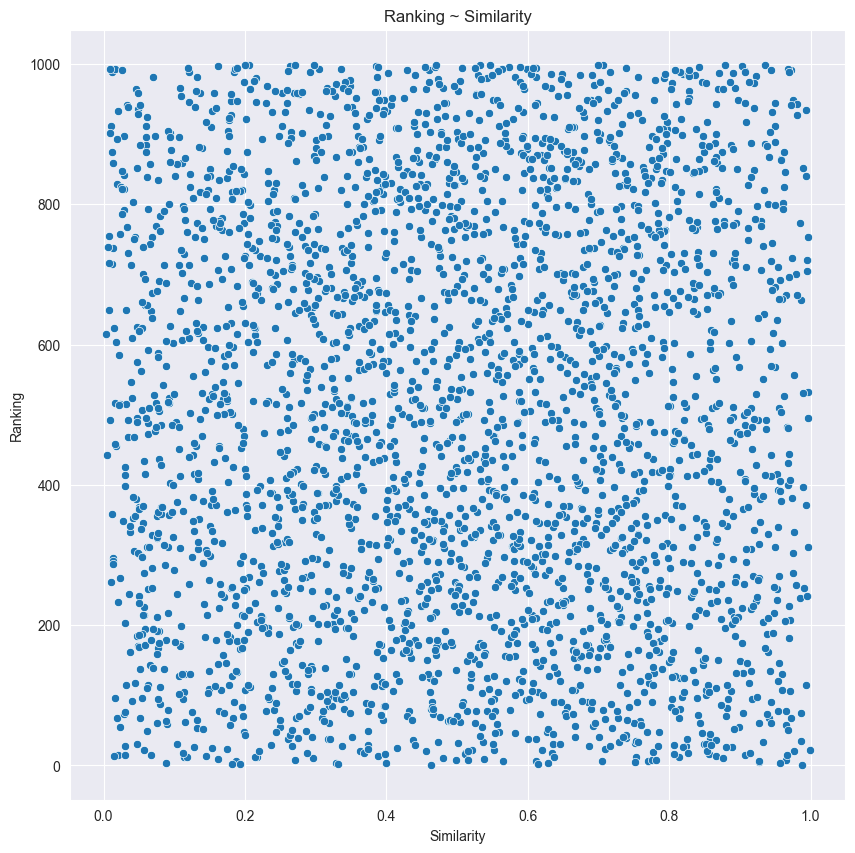

In [212]:
# Task 5.3
from sklearn.isotonic import spearmanr


males = questions[questions.gender == "M"]
females = questions[questions.gender == "F"]

avg_male_ranking = males.ranking.mean()
avg_female_ranking = females.ranking.mean()
ranking_diff = avg_male_ranking - avg_female_ranking

res = ttest_ind(males.ranking, females.ranking)
print(f"The difference in average ranking between males and females is {ranking_diff:.2f}")
if res.pvalue < 0.05:
    print(f"The difference is statistically significant at threshold 0.05 (p-value: {res.pvalue})")
else:
    print(f"The difference is not statistically significant.")

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(questions, x="similarity", y="ranking", ax=ax)
ax.set(
    title="Ranking ~ Similarity",
    xlabel="Similarity",
    ylabel="Ranking",
)

res = spearmanr(questions.ranking, questions.similarity)
print(f"The Spearman Correlation Coefficient is {res.statistic:.3f} (p-val: {res.pvalue:.3f})")

**Task 5.4** True. We have seen that ranking is not statistically significant different between male and female interviewees, and have also established that there is no correlation between the ranking of the player and the similarity score. Hence, we can rule out that ranking is a confounder for the relationship between gender and the similarity score of questions and, under the assumption of no further unobserved confounders, the regression results from 5.1 are still valid and show that females are asked less about the tennis match on average. The below regression analysis, which includes the ranking as well, shows that the coefficient is nearly 0 and not statistically significant.

In [213]:
formula = "similarity ~ C(gender, Treatment(reference='F')) + ranking"
model = smf.ols(formula, data=questions)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     420.4
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          1.15e-161
Time:                        16:09:07   Log-Likelihood:                 77.528
No. Observations:                3000   AIC:                            -149.1
Df Residuals:                    2997   BIC:                            -131.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------